<a href="https://colab.research.google.com/github/PPatrickGU/Projet-Adagos/blob/main/Projet_d'Adagos_imgaeRGB_3_Networks_EarlyStopping_Tensorboard_NeurEco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet d'Adagos**
### ***Author: Zheyi SHEN, Zhaoyi GUAN, Dajing GU & Anastasiya DULEPOVA*** 

## **Libraries imported**

In [ ]:
import cv2
import numpy as np
import pandas as pd
import random
from google.colab import drive
from google.colab.patches import cv2_imshow
import csv


import tensorflow as tf
import tensorflow.keras as keras  
from tensorflow.keras import *
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

import datetime, os

from tensorflow.python.framework import ops
ops.reset_default_graph()

2.4.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# mount my google drive 
drive.mount('/drive')

In [ ]:
# read the image
path_img = '/drive/My Drive/PIC-PROJ/image/Amst.jpg'
img = cv2.imread(path_img)
cv2_imshow(img)

## **Image procession**

In [ ]:
def random_type(img, ratio):
  (h,w,d) = img.shape
  new_img = img.copy()
  num = int(h * w * ratio)
  index_y, index_x = np.random.randint(h,size=num), np.random.randint(w,size=num)
  indexes_pix_masq = np.vstack((index_y, index_x)).transpose(1,0).tolist()
  for i in range(num):
    new_img[index_y[i],index_x[i],:] = 0 
  indexes_pix_non_masq_tmp = [[i,j] for i in range(0,h) for j in range (0,w)]  
  indexes_pix_non_masq = list(set([tuple(t) for t in indexes_pix_non_masq_tmp.copy()]) - set([tuple(t) for t in indexes_pix_masq.copy()]))
  return new_img, indexes_pix_masq, indexes_pix_non_masq


In [ ]:
new_img, indexes_pix_masq, indexes_pix_non_masq = random_type(img,0.4)
cv2_imshow(new_img)
# print(indexes_pix_masq)

In [ ]:
def grid_type(img):
  (h,w,d) = img.shape
  new_img = img.copy()
  indexes_pix_masq = []
  for i in range(0,h,2):
    for j in range(0,w,2):
      new_img[i,j,:] = 0
      indexes_pix_masq.append([i,j])
  indexes_pix_non_masq_tmp = [[i,j] for i in range(0,h) for j in range (0,w)]  # use set to delete the masked elements, use tuple to solve "TypeError: unhashable type: 'list'"
  indexes_pix_non_masq = list(set([tuple(t) for t in indexes_pix_non_masq_tmp.copy()]) - set([tuple(t) for t in indexes_pix_masq.copy()]))
  return new_img, indexes_pix_masq, indexes_pix_non_masq

In [ ]:
# new_img, coordinate = grid_type(img)
new_img, indexes_pix_masq, indexes_pix_non_masq = grid_type(img)
cv2_imshow(new_img)
print(new_img.shape)
print(len(indexes_pix_masq))
print(len(indexes_pix_non_masq))

In [ ]:
def rectangle_type(img, hr, wr):
  (h,w,d) = img.shape
  new_img = img.copy()
  y, x = np.random.randint(h), np.random.randint(w)
  indexes_pix_masq = []
  for i in range(y,min(y+hr,h)):
    for j in range(x,min(x+wr,w)):
      new_img[i,j,:] = 0
      indexes_pix_masq.append([i,j])
  indexes_pix_non_masq_tmp = [[i,j] for i in range(0,h) for j in range (0,w)]  
  indexes_pix_non_masq = list(set([tuple(t) for t in indexes_pix_non_masq_tmp.copy()]) - set([tuple(t) for t in indexes_pix_masq.copy()]))
  return new_img, indexes_pix_masq, indexes_pix_non_masq

In [ ]:
new_img, indexes_pix_masq, indexes_pix_non_masq = rectangle_type(img,100,200)
cv2_imshow(new_img)  

In [ ]:
def vertical_stripes(img):
  (h,w,d) = img.shape
  new_img = img.copy()
  indexes_pix_masq = []
  for i in range(0,h):
    for j in range(0,w,2):
      new_img[i,j,:] = 0
      indexes_pix_masq.append([i,j])
  indexes_pix_non_masq_tmp = [[i,j] for i in range(0,h) for j in range (0,w)]  
  indexes_pix_non_masq = list(set([tuple(t) for t in indexes_pix_non_masq_tmp.copy()]) - set([tuple(t) for t in indexes_pix_masq.copy()]))
  return new_img, indexes_pix_masq, indexes_pix_non_masq

In [ ]:
new_img, indexes_pix_masq, indexes_pix_non_masq = vertical_stripes(img)
cv2_imshow(new_img)
# print(indexes_pix_masq)

In [ ]:
def horizontal_stripes(img):
  (h,w,d) = img.shape
  new_img = img.copy()
  indexes_pix_masq = []
  for i in range(0,h,2):
    for j in range(0,w):
      new_img[i,j,:] = 0
      indexes_pix_masq.append([i,j])
  indexes_pix_non_masq_tmp = [[i,j] for i in range(0,h) for j in range (0,w)]  
  indexes_pix_non_masq = list(set([tuple(t) for t in indexes_pix_non_masq_tmp.copy()]) - set([tuple(t) for t in indexes_pix_masq.copy()]))
  return new_img, indexes_pix_masq, indexes_pix_non_masq

In [ ]:
new_img, indexes_pix_masq, indexes_pix_non_masq = horizontal_stripes(img)
cv2_imshow(new_img)

## **Data generation**

In [ ]:
def Data_train(img, X_train_list):
  ''' 
  Create dataset for model training
  '''
  (h,w,d) = img.shape
  new_img = img.copy()
  coordinate, rgb = [], []
  rgb = [new_img[i,j,:] for [i,j] in X_train_list]
  X_train = np.asarray(X_train_list)
  Y_train = np.asarray(rgb)
  print("Training set: ", X_train.shape, Y_train.shape)
  return X_train, Y_train

In [ ]:
def Data_split(X_train, Y_train, percentage):
  ''' 
  Split dataset for training and calidation
  '''
  state = np.random.get_state()
  np.random.shuffle(X_train)
  np.random.set_state(state)
  np.random.shuffle(Y_train)
  a = int(percentage*X_train.shape[0]) 
  return X_train[a:], Y_train[a:], X_train[0:a], Y_train[0:a]

In [ ]:
def Data_test(img, X_test_list):
  ''' 
  Create dataset for model test
  '''
  (h,w,d) = img.shape
  new_img = img.copy()
  rgb = []
  rgb = [new_img[i,j,:] for [i,j] in X_test_list]
  X_test = np.asarray(X_test_list)
  Y_test = np.asarray(rgb)
  print("Testing set: ", X_test.shape, Y_test.shape)
  return X_test, Y_test

In [ ]:
cv2_imshow(img)
# new_img = rectangle_type(img, 100, 200) #shape [*,*,3]
# new_img, X_test_list = grid_type(img) #shape [*,*,3]
new_img, X_test_list, X_train_list = grid_type(img)
cv2_imshow(new_img)
img2 = img/255
new_img2 = new_img/255 # nomalization


X_train, Y_train = Data_train(new_img2, X_train_list)
X_train, Y_train, X_validation, Y_validation = Data_split(X_train, Y_train, 0.2)
X_test, Y_test = Data_test(img2, X_test_list)
# print(X_train, Y_train)


## **Export Data to .csv**

In [ ]:
a = np.arange(-5,5,1)
print(a)

In [ ]:
name_X, name_Y = ['x','y'], ['r','g','b']

X_train_NeurEco, Y_train_NeurEco = np.concatenate([X_train.copy(),X_validation.copy()]), np.concatenate([Y_train.copy(),Y_validation.copy()])
validation_index = np.arange(X_train.shape[0]+1,X_train_NeurEco.shape[0]+1,1) # the first line is the name of the column

# Dataset_train for NeurEco
X_train_pd, Y_train_pd = pd.DataFrame(columns=name_X,data=X_train_NeurEco), pd.DataFrame(columns=name_Y,data=Y_train_NeurEco)
X_train_pd.to_csv('./X_train.csv',encoding='gbk',index=False)
Y_train_pd.to_csv('./Y_train.csv',encoding='gbk',index=False)

# Validation indices for NeurEco
validation_index_pd = pd.DataFrame(columns=None,data=validation_index)
validation_index_pd.to_csv('./validation_index.csv',encoding='gbk',index=False,header=False)

# Dataset_test for NeurEco
X_test_pd, Y_test_pd = pd.DataFrame(columns=name_X,data=X_test), pd.DataFrame(columns=name_Y,data=Y_test)
X_test_pd.to_csv('./X_test.csv',encoding='gbk',index=False)
Y_test_pd.to_csv('./Y_test.csv',encoding='gbk',index=False)


# X_train_copy = X_train

# Y_train_copy_red = Y_train[:,0]
# Y_train_copy_green = Y_train[:,1]
# Y_train_copy_blue = Y_train[:,2]
# with open('./X_train.csv', 'w') as myfile:
#     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#     wr.writerows(['xy']) # naming the columns, necessary for NeurEco
#     wr.writerows(X_train_copy)

# with open('./Y_train_red.csv', 'w') as myfile:
#     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#     wr.writerow(['r'])
#     wr.writerows(map(lambda x: [x], Y_train_copy_red)) # 'lambda' to make a sequence of lists out of 
#     # list Y_train_copy_red, so when writing to .csv it's a column and not a row

# with open('./Y_train_green.csv', 'w') as myfile:
#     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#     wr.writerow(['g'])
#     wr.writerows(map(lambda x: [x], Y_train_copy_green))

# with open('./Y_train_blue.csv', 'w') as myfile:
#     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#     wr.writerow(['b'])
#     wr.writerows(map(lambda x: [x], Y_train_copy_blue))


## **Model creation using Keras and TensorBoard**

In [ ]:
backend.clear_session()

In [ ]:
# class Network1(keras.Model):
#     def __init__(self):
#         super(Network1, self).__init__()
#         self.fc1 = layers.Dense(units=30, activation='relu')
#         self.fc2 = layers.Dense(units=1, activation='sigmoid')
#     def call(self, inputs, training=None, mask=None):
#         x = self.fc1(inputs)
#         x = self.fc2(x)
#         return x

# class Network2(keras.Model):
#     def __init__(self):
#         super(Network2, self).__init__()
#         self.fc1 = layers.Dense(units=30, activation='relu')
#         self.fc2 = layers.Dense(units=1, activation='sigmoid')
#     def call(self, inputs, training=None, mask=None):
#         x = self.fc1(inputs)
#         x = self.fc2(x)
#         return x

# class Network3(keras.Model):
#     def __init__(self):
#         super(Network3, self).__init__()
#         self.fc1 = layers.Dense(units=30, activation='relu')
#         self.fc2 = layers.Dense(units=1, activation='sigmoid')
#     def call(self, inputs, training=None, mask=None):
#         x = self.fc1(inputs)
#         x = self.fc2(x)
#         return x

In [ ]:
class Network1(keras.Model):
    def __init__(self):
        super(Network1, self).__init__()
        self.fc1 = layers.Dense(units=10, activation='relu', name='Network1_1')
        self.fc2 = layers.Dense(units=10, activation='relu', name='Network1_2')
        self.fc3 = layers.Dense(units=10, activation='relu', name='Network1_3')
        self.fc4 = layers.Dense(units=10, activation='relu', name='Network1_4')
        self.fc5 = layers.Dense(units=10, activation='relu', name='Network1_5')
        self.fc6 = layers.Dense(units=10, activation='relu', name='Network1_6')
        self.fc7 = layers.Dense(units=10, activation='relu', name='Network1_7')
        self.fc8 = layers.Dense(units=10, activation='relu', name='Network1_8')
        self.fc9 = layers.Dense(units=10, activation='relu', name='Network1_9')
        self.fc10 = layers.Dense(units=1, activation='sigmoid', name='Network1_output')
    def call(self, inputs, training=None, mask=None):
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        x = self.fc7(x)
        x = self.fc8(x)
        x = self.fc9(x)
        x = self.fc10(x)
        return x

class Network2(keras.Model):
    def __init__(self):
        super(Network2, self).__init__()
        self.fc1 = layers.Dense(units=10, activation='relu', name='Network2_1')
        self.fc2 = layers.Dense(units=10, activation='relu', name='Network2_2')
        self.fc3 = layers.Dense(units=10, activation='relu', name='Network2_3')
        self.fc4 = layers.Dense(units=10, activation='relu', name='Network2_4')
        self.fc5 = layers.Dense(units=10, activation='relu', name='Network2_5')
        self.fc6 = layers.Dense(units=10, activation='relu', name='Network2_6')
        self.fc7 = layers.Dense(units=10, activation='relu', name='Network2_7')
        self.fc8 = layers.Dense(units=10, activation='relu', name='Network2_8')
        self.fc9 = layers.Dense(units=10, activation='relu', name='Network2_9')
        self.fc10 = layers.Dense(units=1, activation='sigmoid', name='Network2_output')
    def call(self, inputs, training=None, mask=None):
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        x = self.fc7(x)
        x = self.fc8(x)
        x = self.fc9(x)
        x = self.fc10(x)
        return x

class Network3(keras.Model):
    def __init__(self):
        super(Network3, self).__init__()
        self.fc1 = layers.Dense(units=10, activation='relu', name='Network3_1')
        self.fc2 = layers.Dense(units=10, activation='relu', name='Network3_2')
        self.fc3 = layers.Dense(units=10, activation='relu', name='Network3_3')
        self.fc4 = layers.Dense(units=10, activation='relu', name='Network3_4')
        self.fc5 = layers.Dense(units=10, activation='relu', name='Network3_5')
        self.fc6 = layers.Dense(units=10, activation='relu', name='Network3_6')
        self.fc7 = layers.Dense(units=10, activation='relu', name='Network3_7')
        self.fc8 = layers.Dense(units=10, activation='relu', name='Network3_8')
        self.fc9 = layers.Dense(units=10, activation='relu', name='Network3_9')
        self.fc10 = layers.Dense(units=1, activation='sigmoid', name='Network3_output')
    def call(self, inputs, training=None, mask=None):
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        x = self.fc7(x)
        x = self.fc8(x)
        x = self.fc9(x)
        x = self.fc10(x)
        return x

In [ ]:
model1 = Network1() 
model1.build(input_shape=(None, 2)) # num_batch, input_size
model1.summary() # print the network

model2 = Network2() 
model2.build(input_shape=(None, 2)) # num_batch, input_size
model2.summary() # print the network

model3 = Network3() 
model3.build(input_shape=(None, 2)) # num_batch, input_size
model3.summary() # print the network

## **Model training (using Keras)**

In [ ]:
!rm -rf logs

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001,
                              patience=2, verbose=0, mode='auto',
                              baseline=None, restore_best_weights=False) # before: patience=2

logdir1 = os.path.join("logs", "Network1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
logdir2 = os.path.join("logs", "Network2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
logdir3 = os.path.join("logs", "Network3", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback1 = tf.keras.callbacks.TensorBoard(logdir1, histogram_freq=1)
tensorboard_callback2 = tf.keras.callbacks.TensorBoard(logdir2, histogram_freq=1)
tensorboard_callback3 = tf.keras.callbacks.TensorBoard(logdir3, histogram_freq=1)

In [ ]:
model1.compile(optimizer='adam',loss='MAE',metrics=None)
print('Begin training:')
# history1 = model1.fit(X_train, Y_train[:,0], batch_size=128, epochs=1000, validation_split=0.2, shuffle = True, callbacks = [early_stopping])
history1 = model1.fit(X_train, Y_train[:,0], batch_size=128, epochs=50, validation_data=(X_validation, Y_validation[:,0]), shuffle = True, callbacks=[tensorboard_callback1])
# history1 = model1.fit(X_train, Y_train[:,0], batch_size=128, epochs=50, validation_data=(X_validation, Y_validation[:,0]), shuffle = True, callbacks=[early_stopping])
print('Training finished:')


Begin training:
Epoch 1/50
775/775 [==============================] - 6s 4ms/step - loss: 0.1646 - val_loss: 0.1313
Epoch 2/50
775/775 [==============================] - 3s 3ms/step - loss: 0.1273 - val_loss: 0.1195
Epoch 3/50
775/775 [==============================] - 3s 3ms/step - loss: 0.1180 - val_loss: 0.1161
Epoch 4/50
775/775 [==============================] - 3s 3ms/step - loss: 0.1157 - val_loss: 0.1151
Epoch 5/50
775/775 [==============================] - 3s 3ms/step - loss: 0.1148 - val_loss: 0.1142
Epoch 6/50
775/775 [==============================] - 3s 3ms/step - loss: 0.1145 - val_loss: 0.1140
Epoch 7/50
775/775 [==============================] - 3s 3ms/step - loss: 0.1123 - val_loss: 0.1120
Epoch 8/50
775/775 [==============================] - 3s 3ms/step - loss: 0.1082 - val_loss: 0.1074
Epoch 9/50
775/775 [==============================] - 3s 3ms/step - loss: 0.1051 - val_loss: 0.1041
Epoch 10/50
775/775 [==============================] - 3s 3ms/step - loss: 0.1014 - 

In [ ]:
model2.compile(optimizer='adam',loss='MAE',metrics=None)
print('Begin training:')
# history2 = model2.fit(X_train, Y_train[:,1], batch_size=128, epochs=1000, validation_split=0.2, shuffle = True, callbacks = [early_stopping])
history2 = model2.fit(X_train, Y_train[:,1], batch_size=128, epochs=50, validation_data=(X_validation, Y_validation[:,1]), shuffle = True, callbacks=[tensorboard_callback2])
# history2 = model2.fit(X_train, Y_train[:,1], batch_size=128, epochs=50, validation_data=(X_validation, Y_validation[:,1]), shuffle = True, callbacks=[early_stopping])
print('Training finished:')

Begin training:
Epoch 1/50
775/775 [==============================] - 4s 4ms/step - loss: 0.1853 - val_loss: 0.1358
Epoch 2/50
775/775 [==============================] - 3s 3ms/step - loss: 0.1329 - val_loss: 0.1285
Epoch 3/50
775/775 [==============================] - 3s 4ms/step - loss: 0.1261 - val_loss: 0.1274
Epoch 4/50
775/775 [==============================] - 3s 3ms/step - loss: 0.1264 - val_loss: 0.1278
Epoch 5/50
775/775 [==============================] - 3s 3ms/step - loss: 0.1262 - val_loss: 0.1270
Epoch 6/50
775/775 [==============================] - 3s 3ms/step - loss: 0.1263 - val_loss: 0.1274
Epoch 7/50
775/775 [==============================] - 3s 3ms/step - loss: 0.1259 - val_loss: 0.1269
Epoch 8/50
775/775 [==============================] - 3s 3ms/step - loss: 0.1249 - val_loss: 0.1286
Epoch 9/50
775/775 [==============================] - 3s 3ms/step - loss: 0.1252 - val_loss: 0.1272
Epoch 10/50
775/775 [==============================] - 3s 3ms/step - loss: 0.1249 - 

In [ ]:
model3.compile(optimizer='adam',loss='MAE',metrics=None)
print('Begin training:')
# history3 = model3.fit(X_train, Y_train[:,2], batch_size=128, epochs=1000, validation_split=0.2, shuffle = True, callbacks = [early_stopping])
history3 = model3.fit(X_train, Y_train[:,2], batch_size=128, epochs=50, validation_data=(X_validation, Y_validation[:,2]), shuffle = True, callbacks=[tensorboard_callback3])
# history3 = model3.fit(X_train, Y_train[:,2], batch_size=128, epochs=50, validation_data=(X_validation, Y_validation[:,2]), shuffle = True, callbacks=[early_stopping])
print('Training finished:')

Begin training:
Epoch 1/50
775/775 [==============================] - 4s 4ms/step - loss: 0.1432 - val_loss: 0.1080
Epoch 2/50
775/775 [==============================] - 3s 3ms/step - loss: 0.1035 - val_loss: 0.1002
Epoch 3/50
775/775 [==============================] - 3s 3ms/step - loss: 0.0983 - val_loss: 0.0954
Epoch 4/50
775/775 [==============================] - 3s 3ms/step - loss: 0.0934 - val_loss: 0.0956
Epoch 5/50
775/775 [==============================] - 3s 3ms/step - loss: 0.0906 - val_loss: 0.0910
Epoch 6/50
775/775 [==============================] - 3s 3ms/step - loss: 0.0888 - val_loss: 0.0885
Epoch 7/50
775/775 [==============================] - 3s 3ms/step - loss: 0.0879 - val_loss: 0.0905
Epoch 8/50
775/775 [==============================] - 3s 3ms/step - loss: 0.0874 - val_loss: 0.0878
Epoch 9/50
775/775 [==============================] - 3s 3ms/step - loss: 0.0872 - val_loss: 0.0881
Epoch 10/50
775/775 [==============================] - 3s 3ms/step - loss: 0.0863 - 

In [ ]:
print('Begin testing:')
result_r = model1.predict(X_test)
result_g = model2.predict(X_test)
result_b = model3.predict(X_test)
result = np.concatenate((result_r, result_g, result_b), axis = 1)
result_denormalization = result*255 #denormalization
print(result_denormalization)

Begin testing:
[[ 12.271721  35.212624  20.755672]
 [ 20.383764  39.54756   20.275003]
 [ 24.458105  27.728998  21.34199 ]
 ...
 [118.37547  105.16412   89.767944]
 [118.66231  105.1916    89.5546  ]
 [118.94922  105.21904   89.34151 ]]


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

## **Reconstruction of image and calculation of test loss**

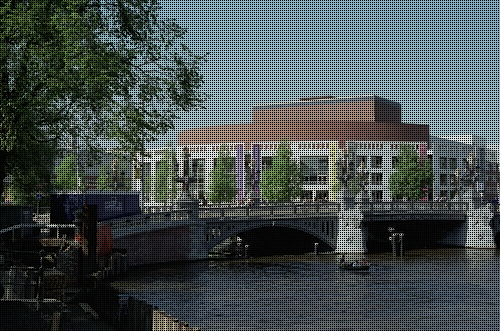

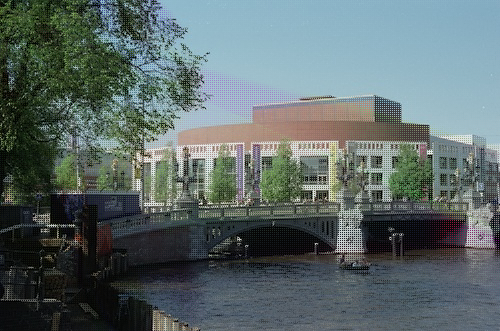

In [ ]:
cv2_imshow(new_img)
# reconstruction of image
reconstructed_img = new_img.copy()

for i in range(len(X_test)):
    x, y = int(X_test[i][0]), int(X_test[i][1])
    r, g, b = result_denormalization[i,:]
    reconstructed_img[x,y,:] = [r,g,b]
cv2_imshow(reconstructed_img)

In [ ]:
# Loss_test = np.linalg.norm(result-Y_test,ord=None,axis=1,keepdims=True)
# # Loss_test_denormalized = np.linalg.norm(result_denormalization-Y_test,ord=None,axis=1,keepdims=True)
# Loss_test_denormalized = np.linalg.norm(result_denormalization-Y_test*255,ord=None,axis=1,keepdims=True)
# Loss_test_percentage = Loss_test/np.linalg.norm(Y_test,ord=None,axis=1,keepdims=True)
# np.linalg.norm(result-Y_test, 'fro') / np.linalg.norm(result, 'fro')

Loss_test = np.linalg.norm(result-Y_test,'fro')
Loss_test_percentage = Loss_test/np.linalg.norm(Y_test,'fro')

print("Loss_test: ", Loss_test)
print("Loss_percentage: ", Loss_test_percentage)

Loss_test:  49.9593747668988
Loss_percentage:  0.30098211125991037


## **Model training (without using Keras): too slow**



In [ ]:
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [ ]:
def train_step(model, inputs, labels): #inputs：X_train; labels：Y_train
  with tf.GradientTape() as tape:
    predictions = model(inputs)
    loss = tf.keras.losses.mean_squared_error(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  train_loss(loss)

In [ ]:
def test_step(model, inputs, labels): #inputs：X_train; labels：Y_train
  predictions = model(inputs)
  t_loss = tf.keras.losses.mean_squared_error(labels, predictions)
  test_loss(t_loss)

In [ ]:
# EPOCHS = 5

# for epoch in range(EPOCHS):
#   # train_loss.reset_states()
#   # test_loss.reset_states()
# # len(X_train)
#   for i in range(1,len(X_train)):
#     train_step(model, X_train[i,:].reshape(1,2), Y_train[i])

#   for i in range(1,len(X_validate)):
#     test_step(model, X_validate, Y_validate)

#   template = 'Epoch {}, Loss: {}, Test Loss: {}'
#   print(template.format(epoch+1,train_loss.result(),test_loss.result()))

## **Reconstruction of image with result of NeurEco**



In [ ]:
# mount my google drive 
drive.mount('/drive')

Mounted at /drive


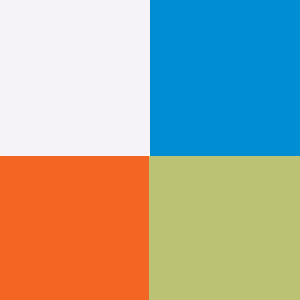

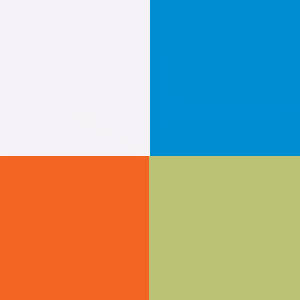

In [ ]:
# read the files
path_dir = '/drive/My Drive/PIC-PROJ/NeurEco_resultat/Figure_JbeQx/grid'
X_train_file = path_dir + '/X_train.csv'
X_test_file = path_dir + '/X_test.csv'
Y_train_file = path_dir + '/Y_train.csv'
Y_test_NeurEco_file = path_dir + '/Validation/X_test_output_neureco.csv'

X_train = np.loadtxt(open(X_train_file),delimiter=',',skiprows=1)
X_test = np.loadtxt(open(X_test_file),delimiter=',',skiprows=1)
Y_train = np.loadtxt(open(Y_train_file),delimiter=',',skiprows=1)
Y_test_NeurEco = np.loadtxt(open(Y_test_NeurEco_file),delimiter=';',skiprows=1)

path_img = '/drive/My Drive/PIC-PROJ/NeurEco_resultat/Figure_JbeQx/JbeQx.png'
img = cv2.imread(path_img)
cv2_imshow(img)

re_img = np.zeros((img.shape))


for i in range(len(X_train)):
    x, y = int(X_train[i][0]), int(X_train[i][1])
    r, g, b = Y_train[i,:]*255
    re_img[x,y,:] = [r,g,b]

for i in range(len(X_test)):
    x, y = int(X_test[i][0]), int(X_test[i][1])
    r, g, b = Y_test_NeurEco[i,:]*255
    re_img[x,y,:] = [r,g,b]
cv2_imshow(re_img)
